In [1]:
import numpy as np
import pandas as pd
from time import sleep 
from math import sqrt
from sklearn import svm
from sklearn import tree
import scipy.stats as scs
from random import randint
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

class Prometheus:
    
    def __init__(self):
        
        self.MODEL = ""
        self.Stack = []
        self.Sample,self.Probes,self.Matrix = [],[],[]
        
    # Nettoyage de données
    def Parser(self,nameFile):
        
        count = 0
        File = open(nameFile,'r')
        File_O = open("GSE26835_Clean.data.txt",'w')
        
        for line in File:
            Temp = line.split()
            Final = [Temp[0]]
            String_O = ""
            
            if(count == 0):
                Final += [e for e in Temp[1:] if "hr" in e]
            
            else:
                Index = -1
                for i in range(1,len(Temp)):
                    if( i < 20 and Temp[i+1] == "like"):
                        continue
                    
                    elif( i < 20 and not '.' in Temp[i+1]):
                        continue
                        
                    else:
                        if ('.' in Temp[i]):
                            if(self.CheckFloat(Temp[i])):
                                Index = i
                                break
                        
                Final += Temp[Index:]
                
            for elem in Final:
                String_O += elem + " "
            String_O += "\n"
            File_O.write(String_O)
            
            count += 1
        
        File.close()
        File_O.close()
    
    def CheckFloat(self,numb):
        Check = True
        
        for e in numb:
            if(not e.isnumeric() and e != '.' ):
                Check = False
                break
                
        return Check
    
    # Ordonner les colonnes par heures croissante
    # Changer les NaN et les valeurs nég en 0
    def OrderMatrix(self):

        count = 0
        File = open("GSE26835_Clean.data.txt",'r')
        Output = open("GSE26835_OrderHourAndIncorrectValueFixed.data.txt","w")
        
        for line in File:
            Output_String = ""
            L = line.split()[:351]
            
            if(count == 0): self.Sample = L[1:]
            
            else:
                self.Probes.append(L[0])
                self.Matrix.append([float(e) for e in L[1:]])
            
            for elem in L:
                if(elem == "NaN" or '-' in elem): elem = "0"
                Output_String += elem + " "
            Output_String += "\n"
            Output.write(Output_String)
            count += 1
        
    #Quantile Normalization
    def partition(self,alist,first,last,row):
        
        pivotvalue = alist[first]
        leftmark = first+1
        rightmark = last
        done = False
    
        while not done:
            while leftmark <= rightmark and alist[leftmark] <= pivotvalue:
                leftmark = leftmark + 1

            while alist[rightmark] >= pivotvalue and rightmark >= leftmark:
                rightmark = rightmark -1

            if rightmark < leftmark: done = True
      
            else:
                temp = alist[leftmark]
                alist[leftmark] = alist[rightmark]
                alist[rightmark] = temp
                if( (row,leftmark) != (row,rightmark)):
                    self.Stack.append([(leftmark,row),(rightmark,row)])

        temp = alist[first]
        alist[first] = alist[rightmark]
        alist[rightmark] = temp
        if( (row,first) != (row,rightmark)):
            self.Stack.append([(first,row),(rightmark,row)])

        return rightmark

    def quickSortHelper(self,alist,first,last,row):
        if(first<last):
            splitpoint = self.partition(alist,first,last,row)
            self.quickSortHelper(alist,first,splitpoint-1,row)
            self.quickSortHelper(alist,splitpoint+1,last,row)

    def quickSort(self,alist,row):
        self.quickSortHelper(alist,0,len(alist)-1,row)

    def Normalize(self):
        
        matrix = []
        Output = open("GSE26835_Quantile.data.txt","w")
        self.Matrix = np.array(self.Matrix)
        self.Matrix = self.Matrix.transpose()

        
        
        for i in range(len(self.Matrix)):
            self.quickSort(self.Matrix[i],i)
            
        self.Matrix = self.Matrix.transpose()
        
        #Moyenne
        for i in range(len(self.Matrix)):
            m = 0
            
            for j in range(len(self.Matrix[i])): m += self.Matrix[i][j]
            m = m/len(self.Matrix[i])
            matrix.append([float(m) for k in range(len(self.Matrix[i]))])
       
        del(self.Matrix)
        
        for ind in range(-1,-len(self.Stack)-1,-1):
            e_1 = self.Stack[ind][0]
            o_1 = self.Stack[ind][1]
        
            matrix[e_1[0]][e_1[1]],matrix[o_1[0]][o_1[1]] = matrix[o_1[0]][o_1[1]],matrix[e_1[0]][e_1[1]]
    
        self.Stack = []
        
        String_O = "Probe "
        
        for e in self.Sample:
            String_O += e + " "
        String_O += "\n"
        
        Output.write(String_O)
        
        
        for i in range(len(matrix)):
            String_O = self.Probes[i] + " "
            for e in matrix[i]:
                String_O += str(e) + " "
            String_O += "\n"
            Output.write(String_O)
        
        del(self.Probes)
        Output.close()
    
    # T-Test pour retirer les données trop variables
    def Preprocessing_Test(self):
        
        count = 0
        File = open("GSE26835_Quantile.data.txt","r")
        Output = open("GSE26835_T_Test.data.txt","w")
        
        for line in File:
            
            Check = False
            Liste = line.split()
            String = ""
            
            if(count != 0):
                Liste_1 = [float(e) for e in Liste[1:208]]
                Liste_2 = [float(e) for e in Liste[208:]]
                a,b = self.T_Test(Liste_1,Liste_2)
                
                if( b <= 0.05): Check = True
                    
            if(count == 0 or Check):
                for e in Liste: String += e + " "
                String += "\n"
                Output.write(String)
            
            count += 1
           
        File.close()
        Output.close()
    
    def T_Test(self,L1,L2):
        
        mean_1 = np.average(L1)
        mean_2 = np.average(L2)
        
        n_1    = len(L1)
        n_2    = len(L2)
        
        var_1  = np.var(L1)
        var_2  = np.var(L2)
        
        num    = abs(mean_1 - mean_2)
        
        a      = (var_1) / n_1
        b      = (var_2) / n_2
        
        denom  = sqrt(a+b)
        
        t      = num / denom
        
        df     = n_1 + n_2 - 2
        
        p      = 2 * (1 - scs.t.cdf(t,df))
        
        return (t,p)

    
    def After_T_Test(self):
        
        count = 0
        Dico_P_Value = {}
        
        File = open("GSE26835_T_Test.data.txt","r")
        Output1 = open("GSE26835_T_Test_EXP1.data.txt","w")
        Output2 = open("GSE26835_T_Test_EXP2.data.txt","w")
        
        for line in File:
            
            Liste = line.split()
            
            if(count != 0):
                
                Liste_1 = [float(e) for e in Liste[1:208]]
                Liste_2 = [float(e) for e in Liste[208:]]
                a,b = self.T_Test(Liste_1,Liste_2)
                
                if(b not in Dico_P_Value): Dico_P_Value[b] = [line]
                    
                else: Dico_P_Value[b].append(line)
            
            else:
                Output1.write(line)
                Output2.write(line)
            count += 1
        File.close()
        
        Liste = []
        for key in Dico_P_Value: Liste.append(key)
        Liste.sort()
        
        for i in range(len(Liste)):
            for elem in Dico_P_Value[Liste[i]]:
                Output1.write(elem)

        for i in range(1,len(Liste)):
            for elem in Dico_P_Value[Liste[i]]:
                Output2.write(elem)
        
        Output1.close()
        Output2.close()
    
    def ConvertToScoreLabel(self,liste):
        
        h0 = sum(liste[:208])
        h6 = sum(liste[208:])
        
        Score = [[h0],[h6]]
        Label = [0,1]
        
        return Score,Label
    
    def GetGoodBadProbes(self,file,limit_begin,bad_begin):
        
        count = 0
        status = "BEGIN"
        GoodProbes, BadProbes, NeutreProbes = {},{},{} 
        
        File = open(file,"r")
        
        for line in File:
            
            Liste = line.split()
            
            if(count != 0):
                if(count == bad_begin): 
                    status = "END"

                if(status == "END"):
                    BadProbes[Liste[0]] = [float(e) for e in Liste[1:]]

                elif(count < limit_begin and status == "BEGIN"):
                    GoodProbes[Liste[0]] = [float(e) for e in Liste[1:]]
                    
                """elif(count >= limit_begin and count < bad_begin):
                    NeutreProbes[Liste[0]] = [float(e) for e in Liste[1:]]"""
                    
                

            count += 1
        
        File.close()
        
        BadKeyProbes = [key for key in BadProbes]
        GoodKeyProbes = [key for key in GoodProbes]  
        
        SetNumber = set()
        TrainingProbes = []
        TestGoodProbes,TestBadProbes = [],[]
        
        # SECTION BONNE PROBES
        
        for i in range(33):
            Liste = []
            while(len(Liste) != 10):
                random = randint(0,len(GoodKeyProbes)-1)
                if(GoodKeyProbes[random] not in Liste):
                    Liste.append(GoodKeyProbes[random])
                    SetNumber.add(random)
            TestGoodProbes.append(Liste)
        
        for i in range(len(GoodKeyProbes)):
            if( i not in SetNumber):
                TrainingProbes.append(GoodProbes[GoodKeyProbes[i]])
        
        """for key in NeutreProbes:
            TrainingProbes.append(NeutreProbes[key])"""
        
        SetNumber = set()
        
        # SECTION MAUVAISES PROBES
        
        for i in range(33):
            Liste = []
            while(len(Liste) != 10):
                random = randint(0,len(BadKeyProbes)-1)
                if(BadKeyProbes[random] not in Liste):
                    Liste.append(BadKeyProbes[random])
                    SetNumber.add(random)
            TestBadProbes.append(Liste)
        
        for i in range(len(BadKeyProbes)):
            if( i not in SetNumber):
                TrainingProbes.append(BadProbes[BadKeyProbes[i]])
        
        X,y = [],[]
        for elem in TrainingProbes:
            a,b = self.ConvertToScoreLabel(elem)
            X.extend(a)
            y.extend(b)
        
        Good, Bad = [],[]
        
        for elem in TestGoodProbes:
            Liste = []
            for e in elem:
                Liste.append(e)
                X_Test,y_Test = self.ConvertToScoreLabel(GoodProbes[e])
                Liste.append(X_Test)
                Liste.append(y_Test)
            Good.append(Liste)
            
        for elem in TestBadProbes:
            Liste = []
            for e in elem:
                Liste.append(e)
                X_Test,y_Test = self.ConvertToScoreLabel(BadProbes[e])
                Liste.append(X_Test)
                Liste.append(y_Test)
            Bad.append(Liste)
        
        return X,y,Good,Bad
    
    def OrganisationProbes(self,F,Test,model,Seuil,I):
        
        for i in range(len(F)):
            count_1 = 0
            print("Set" + str(I[i]) + " :")
            for j in range((len(F[i]))):
                count_1 += 1
                print(F[i][j],end=" ")
                if( count_1 != 0  and count_1%5 == 0): print()
            print("\n")
              
        Best_Probes_Final_Test = []
        
        CountProbesSignature   = {i:0 for i in range(3,11)}
        AverageProbesSignature = {i:0 for i in range(3,11)}
        
        COUNT = 0
        
        for e in F:
            
            currentBestCombi = None
            BestScore = 0
            Dico_Score = {}
            S1 = set()
            for elem in e: S1.add(elem)
            Combi = self.powerSet(S1)
            Combi = [k for k in Combi if(len(k) > 2) ]
            for element in Combi: 
                X_test, y_test = self.GetX_Test_Y_Test(element,Test)
                
                y_prob = model.predict_proba(X_test)[:,1]
                Pro = self.Evaluation(y_test,y_prob,Seuil,"no")
              
                if(Pro >= Seuil):
                    if( (Pro == 100 and self.MODEL == "SVML") or
                        (Pro < 100 and self.MODEL != "SVML")):
                        CountProbesSignature[len(element)] += 1
                        AverageProbesSignature[len(element)] += Pro
                        Dico_Score[str(element)] = Pro
                
                    if(Pro > BestScore):
                        if(Pro == 100 and self.MODEL != "SVML"): pass
                        else:
                            currentBestCombi = element
                            BestScore = round(Pro,6)
         
            print("\nBest subset Set" + str(COUNT) + " : ")
            for e in currentBestCombi: print(e, end=" ")
            print(" avec " + str(BestScore) + "%.")
            
            COUNT += 1
            Final_Current = None
            Best_Score_Final = 0
            
            for element in currentBestCombi:
                Score = 0
                count = 0
                for key in Dico_Score:
                    s = eval(key)
                    if(element in s):
                        Score += Dico_Score[key]
                        count += 1
                Score /= count
                Score = round(Score, 6)
                if( Score > Best_Score_Final ): 
                    Final_Current = element
                    Best_Score_Final = Score
            
            print("En moyenne le probe ",Final_Current, " obtient un score de ",
                  Best_Score_Final, "%.\n")
            Best_Probes_Final_Test.append(Final_Current)
                        
            
        for key in CountProbesSignature:
                if(CountProbesSignature[key] != 0):
                    print(str(key) + " signatures, count = " + 
                          str(CountProbesSignature[key]) + " subsets, " + "average =  " +
                          str(AverageProbesSignature[key]/CountProbesSignature[key]) + "%."
                         )
        
        return Best_Probes_Final_Test
    
    def Training(self,file,limit,end_ind,mod,maxi,Seuil):
        
        count = 0
        
        X,y,TestGood,TestBad = self.GetGoodBadProbes(file,limit,end_ind)
 
        model = None
        SVM,SVML,KNN,TREE = svm.NuSVC(probability=True), \
                            svm.SVC(probability=True,kernel='linear'), \
                            KNeighborsClassifier(n_neighbors=3), \
                            tree.DecisionTreeClassifier()
                            
        if(mod == "MULTIPLE"):
            SVM.fit(X,y)
            SVML.fit(X[:300],y[:300])
            KNN.fit(X,y)
            TREE.fit(X,y)
            
            print("\nKNN : GOOD PROBES SET")
            self.Grouper(KNN,TestGood,TestBad,Seuil)
            print("\nTREE : GOOD PROBES SET")
            self.Grouper(TREE,TestGood,TestBad,Seuil)
            print("SVM : GOOD PROBES SET")
            self.Grouper(SVM,TestGood,TestBad,Seuil)
            self.MODEL = "SVML"
            print("\nSVML : GOOD PROBES SET")
            self.Grouper(SVML,TestGood,TestBad,Seuil)
            
        else:
            if(mod == "SVML"):
                model = svm.SVC(probability=True,kernel='linear')
                self.MODEL = "SVML"
                
            elif(mod == "SVM"):
                model = svm.NuSVC(probability=True)

            elif(mod == "KNN"):
                model = KNeighborsClassifier(n_neighbors=3)

            elif(mod == "TREE"):
                model = tree.DecisionTreeClassifier()
            
            model.fit(X,y)
       
            F,I = self.PrintGraph('b',TestGood,model,1,Seuil)
        
            print( str(len(F)) + " meilleurs Set restant sur les " + str(len(TestGood)) + " de départ " +
                   "à analyser pour conserver les meilleurs probes\n")

            UltimeProbes = self.OrganisationProbes(F,TestGood,model,Seuil,I)
            self.CalculFinal(UltimeProbes,TestGood,model,Seuil)

            N,I = self.PrintGraph('red',TestBad,model,1,Seuil)

            print( str(len(N)) + " meilleurs Set restant sur les " + str(len(TestBad)) + " de départ " +
                   "à analyser pour conserver les meilleurs probes des moins bonnes probes\n")

            UltimeProbes = self.OrganisationProbes(N,TestBad,model,Seuil,I)
            self.CalculFinal(UltimeProbes,TestBad,model,Seuil)
            
    
    def Grouper(self,model,TestGood,TestBad,Seuil):
        
        F,I = self.PrintGraph('b',TestGood,model,1,Seuil)
        
        print( str(len(F)) + " meilleurs Set restant sur les " + str(len(TestGood)) + " de départ " +
                   "à analyser pour conserver les meilleurs probes\n")

        UltimeProbes = self.OrganisationProbes(F,TestGood,model,Seuil,I)
        self.CalculFinal(UltimeProbes,TestGood,model,Seuil)

        """N,I = self.PrintGraph('red',TestBad,model,1,Seuil)

        print( str(len(N)) + " meilleurs Set restant sur les " + str(len(TestBad)) + " de départ " +
                   "à analyser pour conserver les meilleurs probes des moins bonnes probes\n")

        UltimeProbes = self.OrganisationProbes(N,TestBad,model,Seuil,I)
        self.CalculFinal(UltimeProbes,TestBad,model,Seuil)"""
            
    
    def CalculFinal(self,Ultime,Test,model,Seuil):
        
        X_test,y_test = self.GetX_Test_Y_Test(Ultime,Test)
        y_prob = model.predict_proba(X_test)[:,1]
        Pro = self.Evaluation(y_test,y_prob,Seuil,"OK")
    
        print("\nLa combinaison des meilleures probes de chaque Set ", Ultime, " donne ", Pro, "%.")
    
    def GetX_Test_Y_Test(self,probes,test):
        
        X_test, y_test = [],[]
        
        for elem in probes:
            for i in range(len(test)):
                el = test[i]
                if(elem in el):
                    indice = el.index(elem)
                    X_test.extend(el[indice+1])
                    y_test.extend(el[indice+2])
                    break
    
        return X_test, y_test
    
    def PrintGraph(self,colores,Test,model,width,Seuil):
        
        Final_Probes,SetProcent,SetInd = [],[],[]
        Probes_Set = []
        
        for i  in range(len(Test)):
            SetInd.append(i)
            elem = Test[i]
            X_test, y_test, Probes = [],[],[]
            
            for j in range(0,len(elem),3):
                Probes.append(elem[j])
                X_test.extend(elem[j+1])
                y_test.extend(elem[j+2])
            
            y_prob = model.predict_proba(X_test)[:,1]
            Pro = self.Evaluation(y_test,y_prob,Seuil,"no")
            
            if(Pro >= Seuil): 
                Final_Probes.append(Probes)
                Probes_Set.append(i)
            
            SetProcent.append(Pro)
            
        plt.bar(SetInd, SetProcent, width, color=colores )
        plt.show()
    
        return Final_Probes,Probes_Set
    
    def powerSet(self,myset):
    
        if( not myset): return [set()]
    
        r = []
    
        for y in myset:
            sy = set((y,))
            for x in self.powerSet(myset - sy):
                if(x not in r):
                    r.extend([x,x|sy])
        return r
    
    def Evaluation(self,Y_test,y_prob,Seul,status):
        
        F_Plus,T_Plus,Seuil = roc_curve(Y_test,y_prob)
        roc_auc             = auc(F_Plus,T_Plus) *100
        
        # Plot the ROC graph
        if(roc_auc >= Seul and status == "OK"):
            plt.plot(F_Plus, T_Plus, label='ROC curve (area = %0.3f)' % roc_auc)
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.0])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC')
            plt.legend(loc="lower right")
            plt.show()

        return roc_auc

In [2]:
Pro = Prometheus()

In [ ]:
Pro.Parser("GSE26835.data.txt")

In [ ]:
Pro.OrderMatrix()

In [ ]:
Pro.Normalize()

In [ ]:
Pro.Preprocessing_Test()

In [ ]:
Pro.After_T_Test()


KNN : GOOD PROBES SET


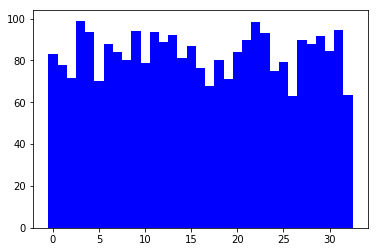

11 meilleurs Set restant sur les 33 de départ à analyser pour conserver les meilleurs probes

Set3 :
209248_at 207350_s_at 205394_at 202189_x_at 209200_at 
201055_s_at 202167_s_at 206188_at 208718_at 204481_at 


Set4 :
208943_s_at 204033_at 202863_at 201609_x_at 205500_at 
201459_at 202268_s_at 204285_s_at 205024_s_at 201637_s_at 


Set9 :
208709_s_at 207988_s_at 201954_at 205217_at 201543_s_at 
200742_s_at 209100_at 206550_s_at 202760_s_at 202858_at 


Set11 :
201753_s_at 206303_s_at 201088_at 205189_s_at 201555_at 
201705_at 201516_at 208985_s_at 202534_x_at 208718_at 


Set13 :
204711_at 208392_x_at 204372_s_at 204593_s_at 201606_s_at 
200690_at 201020_at 204245_s_at 206687_s_at 208668_x_at 


Set21 :
205022_s_at 204905_s_at 201138_s_at 201592_at 201298_s_at 
204859_s_at 205053_at 204146_at 204428_s_at 201930_at 


Set22 :
203696_s_at 209025_s_at 204033_at 202468_s_at 203451_at 
201055_s_at 209162_s_at 1294_at 202731_at 204118_at 


Set23 :
1729_at 208718_at 208898_at 204234_s_at 2

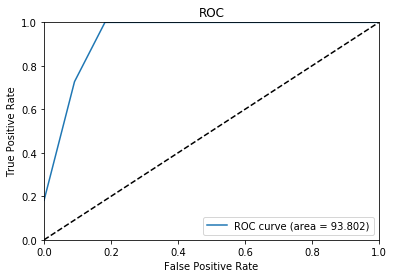


La combinaison des meilleures probes de chaque Set  ['208718_at', '202863_at', '208709_s_at', '205189_s_at', '200690_at', '204146_at', '201055_s_at', '208898_at', '201558_at', '200956_s_at', '202469_s_at']  donne  93.80165289256198 %.

TREE : GOOD PROBES SET


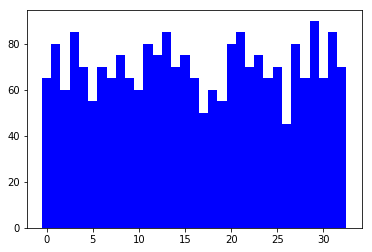

1 meilleurs Set restant sur les 33 de départ à analyser pour conserver les meilleurs probes

Set29 :
200956_s_at 201703_s_at 209375_at 201753_s_at 205761_s_at 
209330_s_at 208749_x_at 205182_s_at 206569_at 201516_at 



Best subset Set0 : 
209330_s_at 200956_s_at 208749_x_at 201516_at 209375_at 205182_s_at 206569_at 201753_s_at 201703_s_at  avec 94.444444%.
En moyenne le probe  209330_s_at  obtient un score de  91.497767 %.

5 signatures, count = 140 subsets, average =  90.0%.
6 signatures, count = 112 subsets, average =  91.66666666666664%.
7 signatures, count = 56 subsets, average =  92.85714285714285%.
8 signatures, count = 16 subsets, average =  93.75%.
9 signatures, count = 2 subsets, average =  94.44444444444444%.
10 signatures, count = 1 subsets, average =  90.0%.


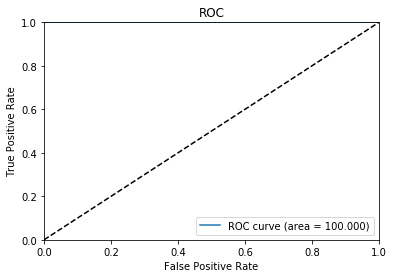


La combinaison des meilleures probes de chaque Set  ['209330_s_at']  donne  100.0 %.
SVM : GOOD PROBES SET


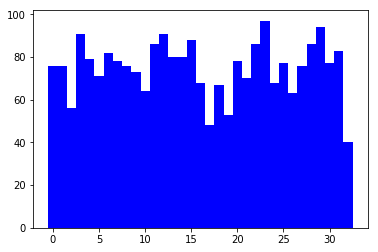

4 meilleurs Set restant sur les 33 de départ à analyser pour conserver les meilleurs probes

Set3 :
209248_at 207350_s_at 205394_at 202189_x_at 209200_at 
201055_s_at 202167_s_at 206188_at 208718_at 204481_at 


Set12 :
202625_at 203590_at 204248_at 203310_at 204613_at 
201298_s_at 201573_s_at 201937_s_at 205052_at 201459_at 


Set23 :
1729_at 208718_at 208898_at 204234_s_at 204728_s_at 
201388_at 201641_at 202863_at 202845_s_at 205034_at 


Set29 :
200956_s_at 201703_s_at 209375_at 201753_s_at 205761_s_at 
209330_s_at 208749_x_at 205182_s_at 206569_at 201516_at 



Best subset Set0 : 
209200_at 201055_s_at 202167_s_at 204481_at 206188_at 207350_s_at 208718_at 205394_at  avec 98.4375%.
En moyenne le probe  204481_at  obtient un score de  93.974552 %.


Best subset Set1 : 
204613_at 204248_at 201298_s_at 201573_s_at 203590_at 201459_at 203310_at 201937_s_at 202625_at  avec 98.765432%.
En moyenne le probe  204613_at  obtient un score de  96.080959 %.


Best subset Set2 : 
204234_s_at 208

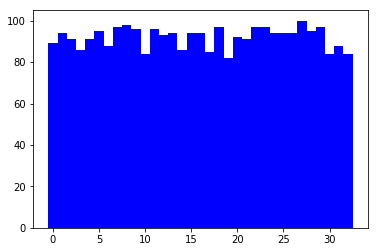

23 meilleurs Set restant sur les 33 de départ à analyser pour conserver les meilleurs probes

Set1 :
202115_s_at 207606_s_at 200027_at 202548_s_at 204484_at 
200658_s_at 203158_s_at 205210_at 202626_s_at 206150_at 


Set2 :
200097_s_at 202426_s_at 207168_s_at 204504_s_at 200941_at 
202864_s_at 203689_s_at 200915_x_at 200750_s_at 203544_s_at 


Set4 :
208943_s_at 204033_at 202863_at 201609_x_at 205500_at 
201459_at 202268_s_at 204285_s_at 205024_s_at 201637_s_at 


Set5 :
208740_at 202107_s_at 207842_s_at 202578_s_at 203733_at 
201174_s_at 202217_at 209100_at 203806_s_at 203837_at 


Set7 :
201964_at 201936_s_at 205552_s_at 205909_at 204756_at 
200679_x_at 208289_s_at 204494_s_at 200711_s_at 202158_s_at 


Set8 :
207541_s_at 204804_at 203847_s_at 207719_x_at 206066_s_at 
206554_x_at 206687_s_at 207641_at 206052_s_at 200604_s_at 


Set9 :
208709_s_at 207988_s_at 201954_at 205217_at 201543_s_at 
200742_s_at 209100_at 206550_s_at 202760_s_at 202858_at 


Set11 :
201753_s_at 206303_s_at 201

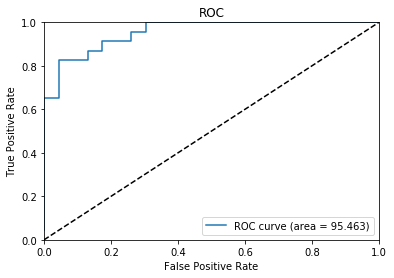


La combinaison des meilleures probes de chaque Set  ['202548_s_at', '203544_s_at', '204285_s_at', '207842_s_at', '204756_at', '206066_s_at', '207988_s_at', '201088_at', '201298_s_at', '208392_x_at', '205548_s_at', '205922_at', '203278_s_at', '205224_at', '204146_at', '203696_s_at', '204234_s_at', '203544_s_at', '200752_s_at', '201585_s_at', '201558_at', '204995_at', '209330_s_at']  donne  95.46313799621929 %.


In [3]:
Pro.Training("GSE26835_T_Test_EXP1.data.txt",1001,9356,"MULTIPLE",30000,90)

In [ ]:
Pro.Training("GSE26835_T_Test_EXP1.data.txt",1001,9356,"SVM",30000,90)

In [ ]:
Pro.Training("GSE26835_T_Test_EXP1.data.txt",201,10256,"SVML",30000,90)

In [ ]:
Pro.Training("GSE26835_T_Test_EXP1.data.txt",1001,9356,"TREE",30000,80)

In [ ]:
print("Set0 : 202706_s_at 202707_s_at 202708_s_at 202709_s_at 202710_s_at 202711_s_at 202712_s_at 202713_s_at 202714_s_at 202715_s_at '")

